# How to run this file?
In this file, there are three cells: 'define functions', 'simulation', 'graphing' cell. 
- First, run the 'define functions' cell to define functions.
- After you run 'define functions' cell, you will see 'config parameters' section explains the parameters you can change in the next cell ('simulation' cell).
- After you modify parameters, run the 'simulation' cell. You will see '-------Simulation Start----------',..., until'----------Simulation Finished---------', meaning simulation completed. The processing time depends on the game length you select.
- Finally, run the 'graphing' cell. The result shows dynamics graphs over periods. The top left graph shows payoffs for each strategies over periods; The top right graph shows cdf; the bottom graph shows strategies over periods. 

New added:
- a dynamics with average payoffs compared to the NE payoff.
- modify the selection distance depends on bubble and max(y)
- evaulate sampling

Version 1.1
- modify ux function to classic
- gradually change v(q)function (as many as possible)

In [1]:
#########################################################
########## run this cell to define functions ############
############### 'define functions' cell #################
#########################################################


########## configuration ############
import math

def sim_config_init(initial_distribution = 'uniform', initial_xrange=(2,5), initial_sigma=1,initial_mu=1, trembling=0., num_bots=20, move_percent = 0.1, game_length=1000, 
                    xrange=(2,10), theta=10, signal_form='uniform', signal_xrange=(2,5), signal_sigma=0.5, weight_to_theta=0.5, positive_constant=100, x_bar='mean', percentile=50, exp=False,lam=10,gam=1,c=0.5,k=1):
    '''
    Specify simulation configuration parameters
    :param game_type: string, game type
    :param lgr: tuple, (lambda, gamma, rho), default to (10,1.1,0.5)
    :param sampling: int, number of players to sample (give each player an array of random other players to sample), default to None
    :param purification: idiosyncratic shifts of perceived landscape
    :param trembling: float, trembling range, default to 0, trembles in jump destination
    :param bandwidth: float, smoothing bandwidth, default to None
    :param num_bots: int, number of bots, default to 20
    :param game_length: int, game length, default to 1000
    :param xrange: tuple, strategy range
    :return: config, dictionary containing all simulation configuration parameters
    '''

    config = {}

    # the initial distribution of x( or action) could be 'uniform' or 'normal' or 'clump'
    config['initial_distribution'] = initial_distribution
    
    # initial variance if use normal distribution
    config['initial_sigma'] = initial_sigma

    # initial mean if use normal distribution
    config['initial_mu'] = initial_mu
    
    # trembling range
    # set to 0 to have no effect
    config['trembling'] = trembling
    
    
    # initial distribution range
    config['initial_xmin'] = initial_xrange[0]
    config['initial_xmax'] = initial_xrange[1]  
    
    # signal uniform distribution range
    config['signal_xmin'] = signal_xrange[0]
    config['signal_xmax'] = signal_xrange[1]  
    
    # action range
    config['xmin'] = xrange[0]
    config['xmax'] = xrange[1]    
    
    # number of bots
    config['num_bots'] = num_bots
    
    # move percentage
    config['move_percent'] = move_percent

    # game length
    config['game_length'] = game_length
    
    
    # theta - state
    config['theta'] = theta
    
    # the signal distribution could be 'uniform' or 'normal'
    config['signal_form'] = signal_form
    
    # theta - state
    config['signal_sigma'] = signal_sigma
    
    # weight assign to theta - r
    config['weight_to_theta'] = weight_to_theta

    # positive part for loss function
    config['positive_constant'] = positive_constant
    
    # x_bar
    config['x_bar'] = x_bar
    
    # percentile
    config['percentile'] = percentile
    
    # whether exponentiate
    config['exp'] = exp
    
    # when change to classical ux function
    config['lambda'] = lam
    
    config['gamma'] = gam
    
    config['c'] = c
    config['k'] = k
    
    return config

########## functions ############

# import numpy as np



# def get_y(n, strategies, config):
#     num_bots = config['num_bots']
#     theta = config['theta']
#     r = config['weight_to_theta']
#     positive_constant = config['positive_constant']
    
# def get_individual_L(n, strategies, config):
#     num_bots = config['num_bots']
#     theta = config['theta']
#     r = config['weight_to_theta']
#     positive_constant = config['positive_constant']   
#     L = 0
#     for i in range(len(strategies)):
#         L += (strategies[i] - n)**2
#     return L

# def data_logging(var_name_list, round_num, history):
#     for var in var_name_list:
#         history[var, round_num] = eval({var})

#     return history


########## simulation functions ############
import random
import numpy as np
import pandas as pd
import math
# from timing_games_package import Functions as fun



def get_position(n, strats, config):
    '''

    :param n: float, timing n
    :param seed: index of player i, default to none
    :param strats: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :param config: dict, dictionary containing simulation parameters
    :return: float, position for timing n
    '''
    # positions are approximated more accurately by adding 0 to the value for greed and 1 for fear game
    pos=0.5
    for strat in strats:
        if n > strat:
            pos = pos + 1
    return pos

# Returns ties at timing n
# optional parameter seed denotes which set of players to sample (-1 for no sampling)
def get_tie(n, strats, config):
    '''

    :param n: float, timing n
    :param seed: index of player i, default to none
    :param strats: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :param config: dict, dictionary containing simulation parameters
    :return: float, ties for timing n
    '''
    # this is only here to fix rounding comparison issues
    n = round(n,2)

    tie = 0
    for strat in strats:
        # more rounding stuff due to float precision errors
        strat = round(strat, 2)
        if n == strat:
            tie = tie + 1
    return tie

def initialize_player_strategies(config):
    '''
    Function to run first simulation step to initialize each player's initial strategy
    :param config: dict, dictionary contains simulation parameters
    :return: array, initial strategies;  ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    '''
    # game type for starting distribution: set to 'uniform' or 'normal' for respective distributions
    #For uniform needs to set initial xrange
    #For normal needs to set initial sigma

    initial_distribution = config['initial_distribution']
    num_bots = config['num_bots']
    
    #uniform distribution
    if initial_distribution == 'uniform':
        initial_xmin = config['initial_xmin']
        initial_xmax = config['initial_xmax']
        
        #action for each bot
        strategies_list = []
        
        for i in range(num_bots):
            strategies_list.append(random.random() * (initial_xmax - initial_xmin) + initial_xmin)
        strategies = np.array(strategies_list)
        
    #normal distribution
    elif initial_distribution == 'normal':
        initial_sigma = config['initial_sigma']
        initial_mu = config['initial_mu']
        strategies = np.random.normal(initial_mu, initial_sigma, num_bots)

         


    strategies = np.round(strategies, 2)
    strategies = np.sort(strategies)

#     # apply sampling
#     for i in range(num_bots):
#         if sampling is not None:
#             other_player_index_list = list(range(num_bots))
#             other_player_index_list.remove(i)
#             to_add = random.sample(other_player_index_list, sampling)
#             sample_sets.append(to_add)
            
#     initial_strategies = strategies

    return strategies



def generate_private_signal(config):
    
    theta = config['theta']
    num_bots = config['num_bots']
    signal_form = config['signal_form']
    
    if signal_form == 'uniform':
        signals_list = []
        signal_xmin = config['signal_xmin']
        signal_xmax = config['signal_xmax']
        for i in range(num_bots):
            signals_list.append(random.random() * (signal_xmax - signal_xmin) + signal_xmin)
        signals = np.array(signals_list) 
        
    elif signal_form == 'normal':
        signal_sigma = config['signal_sigma']
        signals = np.random.normal(0, signal_sigma, num_bots)
        signals = signals + theta
    signals = np.round(signals, 2)
    signals = np.sort(signals)
    
    return signals

    
def calculate_payoff(config, strategies, signals):
    num_bots = config['num_bots']
    theta = config['theta']
    r = config['weight_to_theta']
    positive_constant = config['positive_constant']
    x_bar = config['x_bar']
    percent = config['percentile']
    exp = config['exp']
    lam = config['lambda']
    gam = config['gamma']
    c = config['c']
    k = config['k']


    #payoff
    strategies_y = []
    if exp is False:
        if x_bar == 'mean':
            for i in range(len(strategies)):
                payoff = positive_constant - r*(strategies[i]-signals[i])**2 - (1-r)*(strategies[i]-strategies.mean())**2
                strategies_y.append(payoff)
        else:
            for i in range(len(strategies)):
                payoff = positive_constant - r*(strategies[i]-signals[i])**2 - (1-r)*(strategies[i]-np.percentile(strategies, percent))**2
                strategies_y.append(payoff)
    else:
        for i in range(len(strategies)):
#             u = math.exp(-(strategies[i]-signals[i])**2)
            u = 1 + 2*lam*strategies[i] - strategies[i]**2
#             v = math.exp(-(strategies[i]-np.percentile(strategies, percent))**2)
#             v = math.exp(-(1-np.percentile(strategies, percent))**2)
            ties = get_tie(strategies[i], strategies, config)
            pos = get_position(strategies[i], strategies, config)
            if ties == 0:
                q = pos/len(strategies)
                v = math.exp(-k*(q-gam)**2)+c
            # if there are ties, calculate the average of the position components over the tie range
            elif ties > 0:
                v = 0
                for j in range(ties):
                    v += math.exp(-k*((pos+j)/len(strategies)-gam)**2)+c
                v = v/ties
            payoff = u*v
            strategies_y.append(payoff)
#         print('median is {}'.format(np.percentile(strategies, percent)))
    return strategies_y

def get_landscape(strats, config):
    '''
    calculate players' payoffs at period t w/o purification (only use for the selected players) 
    :param n: float, timing n
    :param strats: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :param config: dict, dictionary containing simulation parameters
    :param seed: index of player i, default to none
    :param use_bandwidth:
    :return: float, payoff
    '''
    num_bots = config['num_bots']
    theta = config['theta']
    r = config['weight_to_theta']
    positive_constant = config['positive_constant']
    x_bar = config['x_bar']
    percent = config['percentile']
    exp = config['exp']
    lam = config['lambda']
    c = config['c']
    k = config['k']
    gam = config['gamma']
    xmax = config['xmax']
    xmin = config['xmin']
    
    x = np.round(np.arange(xmin, xmax, 0.01),2)
    y = []
    quantile = []
    for val in x:
        u = 1 + 2*lam*val - val**2
        ties = get_tie(val, strats, config)
        pos = get_position(val, strats, config)
        if ties == 0:
            q = pos/len(strategies)
            v = math.exp(-k*(q-gam)**2)+c
            quantile.append(q)
            # if there are ties, calculate the average of the position components over the tie range
        elif ties > 0:
            v = 0
            total_quantile = 0
            for j in range(ties):
                v += math.exp(-k*((pos+j)/len(strategies)-gam)**2)+c
                total_quantile += (pos)/len(strategies)
            v = v/ties
            total_quantile = total_quantile/ties
            quantile.append(total_quantile)
        payoff = u*v
        y.append(payoff)
    y = np.array(y)
    quantile = np.array(quantile)
    quantile = quantile - 0.5/config['num_bots']
    return x, y, quantile

    
        
def update_strategies(strategies, signals, strategies_y, config):
    
    num_bots = config['num_bots']
    theta = config['theta']
    r = config['weight_to_theta']
    positive_constant = config['positive_constant']
    trembling = config['trembling']
    move_size = round(config['move_percent'] *config['num_bots'])
    xmax = config['xmax']
    xmin = config['xmin']
    x_bar = config['x_bar']
    percent = config['percentile']
    exp = config['exp']
    lam = config['lambda']
    gam = config['gamma']
    c = config['c']
    k = config['k']
    
    x = np.round(np.arange(xmin, xmax, 0.01),2)
    static_strategies = strategies.copy()
    
    best_strategies_y = max(strategies_y)
    strategies_y = np.array(strategies_y)
    distances_from_best_payoff = best_strategies_y - strategies_y
    players_index = list(range(len(strategies)))
    
    n=0
    selected_player_index = set([])
    while n < move_size:
#         print('players_index is {}'.format(players_index))
#         print('distances_from_best_payoff is {}'.format(distances_from_best_payoff))
        chosen_one = random.choices(players_index, weights=distances_from_best_payoff,k=1)
#         print('chosen_one is {}'.format(chosen_one))
        selected_player_index.update(chosen_one)
#         print('selected_player_index is {}'.format(selected_player_index))
        index = players_index.index(chosen_one[0])
#         print('index is {}'.format(index))
        del players_index[index]
#         print('new players_index is {}'.format(players_index))
        distances_from_best_payoff = np.delete(distances_from_best_payoff, index)
#         print('new distances_from_best_payoff is {}'.format(distances_from_best_payoff))
        n+=1
#         print(n)
        sum_weights = math.fsum(distances_from_best_payoff)
#         print('sum weights is {}'.format(sum_weights))
        if sum_weights == 0:
            break
    if len(selected_player_index) != move_size:
        remaining = random.sample(players_index,k=move_size-n)
#         print('remaining is {}'.format(remaining))
        selected_player_index.update(remaining)
#         print(selected_player_index)

#     print('selected {}'.format(selected_player_index))
    for i in selected_player_index:
#         print('i= {}'.format(i))
        potential_strategies = static_strategies.copy()
#         print('potential_strategies {}'.format(potential_strategies))
        y1 = [] #calculate landscape for selected player
        if exp is False:
            if x_bar == 'mean':
                for val in x:
                    potential_strategies[i] = val
                    payoff = positive_constant - r*(potential_strategies[i]-signals[i])**2 - (1-r)*(potential_strategies[i]-potential_strategies.mean())**2
                    y1.append(payoff)
            else:
                for val in x:
                    potential_strategies[i] = val
                    payoff = positive_constant - r*(potential_strategies[i]-signals[i])**2 - (1-r)*(potential_strategies[i]-np.percentile(potential_strategies, percent))**2
                    y1.append(payoff)
        else:
            for val in x:
                potential_strategies[i] = val
#                 u = math.exp(-(potential_strategies[i]-signals[i])**2)
                u = 1 + 2*lam*potential_strategies[i] - potential_strategies[i]**2
#                 v = math.exp(-(potential_strategies[i]-np.percentile(potential_strategies, percent))**2)
#                 v = math.exp(-(1-np.percentile(potential_strategies, percent))**2)
                ties = get_tie(potential_strategies[i], potential_strategies, config)
                pos = get_position(potential_strategies[i], potential_strategies, config)
                if ties == 0:
                    q = pos/len(strategies)
                    v = math.exp(-k*(q-gam)**2)+c
                # if there are ties, calculate the average of the position components over the tie range
                elif ties > 0:
                    v = 0
                    for j in range(ties):
                        v += math.exp(-k*((pos+j)/len(strategies)-gam)**2)+c
                    v = v/ties                
                payoff = u*v
                y1.append(payoff)
#         print('x {}'.format(x))
#         print('y1 {}'.format(y1))
                
        best = max(y1)
        
        # if there are multiple timings with the best payoff, choose randomly
        indices = [k for k, j in enumerate(y1) if j == best]
#         print('indices is {}'.format(indices))
        best_choice = random.choice(indices)
        best_choice = x[best_choice] 
        
        if best_choice != strategies[i]:    
            strategies[i] = best_choice + round((random.random() * trembling - trembling/2), 2)
#         print('strategies {}'.format(strategies))
    return strategies
            
            
        
           

# from timing_games_package import Simulation
# from timing_games_package.Configuration import sim_config_init
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
from matplotlib import style
import numpy as np
import pandas as pd
plt.style.use('default')

# config parameters (you can change values in the cell below)

`game_type`: game type. It could be 'fear' or 'greed', or 'other'.
- `game_type` is optional for only fear or only greed game. For example, if you specify `game_type='greed'` while $\gamma \leq \rho + 2/3$, the code will override game type you specified and force it to 'fear' instead.
- If you choose 'other', the initial strategies will be selected based on uniform distribution. You need to specify the range `xrange`.

`lgr`: lambda/gamma/rho params: (lambda, gamma, rho)
- `lgr=(10,1.1,0.5)` means (lambda, gamma, rho)=(10, 1.1, 0.5)

||game type|
|--|--|
|$\gamma \leq \rho + 2/3$|only fear game|
|$\rho + 2/3 < \gamma < \rho + 4/3 $|fear or greed equilibrium|
|$\gamma \geq \rho + 4/3 $|only greed|


`sampling`: number of players to sample. Give each player an array of random other players to sample, default to None.
- `sampling=None` means players could observe all other players' moves.
- `sampling=5` means players could only observe 5 other players' moves.

`purification`: idiosyncratic shifts of perceived landscape. It could be 0.1, 0.2 etc.
- u(x)v((1-e)q), with e=2di/(N-1)-d for i=0,...N-1 when num_bots=N. Specifically, d=purification.
- `purification=None` meaning purification is disabled.


`trembling`: trembling range (set to 0 to have no effect. It could be 0.1, 0.2, etc

`bandwidth`: smoothing bandwidth (set None to disable). It could be 0.1, 0.2, etc


`num_bots`: number of bots

`move_percent`: the percent of players that move each period. It could be 0.1, 0.2, etc.
- fully asynchronous if `move_percent=1/number of bots` (meaning only one player moves per period)
- fully synchronous if `move_percent=1.0` (meaning all players move per period)

Example: if `num_bots=20` and `move_percent=0.05`, we have fully asynchronicity; if `num_bots=20` and `move_percent=1.0`, we have fully synchronicity.


`game_length`: game length. Simulation periods

`xrange`: you need to specify x range if the game type is 'other'.



# selected parameters based on theory

|$\lambda$|$\gamma$|$\rho$|game type|rush size|rush time|slow play on|Nah payoff|
|--|--|--|--|--|--|--|--|
|10|1.1|0.5| only fear|q0=0.45|1.26|[1.26,10]| 27.545| 
|10|1.5|0.5| fear equilibrium|q0=0.75|5.51|[5.51,10]| 100.90|
|10|1.5|0.5| greed equilibrium|q1=0.25|14.49|[10,14.49]| 101|
|10|2|0.5| only greed|q1=0.725|15.97|[10,15.97]| 101|
|10|2.5|2| only fear|q0=0.375|6.69|[6.69,10]| 90.9| 
|10|2.5|1.7| fear equilibrium|q0=0.6|7.28|[7.28,10]| 96.2|
|10|2.5|1.7| greed equilibrium|q1=0.1|11.27|[10,11.27]| 101|
|10|2.5|1.3| fear equilibrium|q0=0.9|8.58|[8.58,10]| 107.2|
|10|2.5|1.3| greed equilibrium|q1=0.4|13|[10,13]| 101|
|10|2.5|1| only greed|q1=0.625|14.25|[10,14.25]| 101|
|10|3|2| fear equilibrium|q0=0.75|8.25|[8.25,10]| 101|
|10|3|2| greed equilibrium|q1=0.25|11.74|[10,11.74]| 101|
|10|3.6|2| only greed|q1=0.7|12.85|[10,12.85]| 101|


In [11]:
####################################################################################
########## run this cell to run simulation after you change parameters ############
############################### 'simulation' cell #################################
####################################################################################
from datetime import datetime
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

start=datetime.now()

history = {}
round_idx = 0

# Set up simulation configuration
#####################################
### you can change parameters here ###
#####################################
sim_config = sim_config_init(
    initial_distribution = 'uniform', 
    initial_xrange=(8,12), #use if initial distribution is uniform
    initial_sigma=1, #use if initial distribution is normal
    initial_mu=8, #use if initial distribution is normal
    trembling=0.2, 
    num_bots=20, 
    move_percent = 1, 
    game_length=200, 
    xrange=(5,18), 
    theta=10, 
    signal_form='uniform', 
    signal_xrange=(10,10), #use if signal distribution is uniform
    signal_sigma=0.5, #use if signal distribution is normal
    weight_to_theta=0.2, 
    positive_constant=100,
    x_bar = 'percentile', #can be mean or percentile
    percentile = 90, #use if x_bar = 'percentile'
    exp=True,
    lam=10,
    gam=0.7,
    c=0.,
    k=0.2,
)


# Simulate players' initial strategies and payoffs
strategies = initialize_player_strategies(sim_config)
print(strategies)
signals = generate_private_signal(sim_config)
print(signals)
strategies_y = calculate_payoff(sim_config, strategies, signals)
print(strategies_y)
x,y,quantile = get_landscape(strategies, sim_config)
# Log data for the initial round
history['strategies', round_idx] = strategies.copy()
history['strategies_y', round_idx] = strategies_y
history['quantile', round_idx] = quantile
history['x', round_idx] = x
history['y', round_idx] = y
# history['selected_player_index', round_idx] = None


# Iterate simulation to update players' strategies and payoff
max_game_length = sim_config['game_length']

print('----------------Simulation Start----------------')
print('Period 0 done')
while round_idx < max_game_length:
    round_idx += 1
    strategies = update_strategies(strategies, signals, strategies_y, sim_config)
#     print(strategies)
    strategies_y = calculate_payoff(sim_config, strategies, signals)
    x,y,quantile = get_landscape(strategies, sim_config)
#     print(strategies_y)
    # Log data for the round
    history['strategies', round_idx] = strategies.copy()
    history['strategies_y', round_idx] = strategies_y
    history['quantile', round_idx] = quantile
    history['x', round_idx] = x
    history['y', round_idx] = y
#     history['selected_player_index', round_idx] = selected_player_index   
    if round_idx%20 == 0:
        print('Period {} done'.format(round_idx))
    
print('----------------Simulation Finished----------------')


print('simulation spent time: {}'.format(datetime.now()-start))

[ 8.3   8.33  8.56  8.68  8.74  9.39  9.7   9.78 10.09 10.45 10.57 10.72
 11.05 11.06 11.21 11.23 11.56 11.63 11.82 11.89]
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.]
[89.56497129515957, 90.830419279658, 92.59648104968706, 93.93410172490135, 95.02612505493046, 97.05759403104243, 98.11144539671163, 98.84136528073984, 99.47589122960707, 99.78207457842953, 100.06034960747135, 100.16808512213566, 99.78517850518722, 99.86391623025187, 99.52345879009182, 99.37523994557836, 98.2588607803068, 97.74258945342508, 96.70350344589689, 95.96539111680276]
----------------Simulation Start----------------
Period 0 done
Period 20 done
Period 40 done
Period 60 done
Period 80 done
Period 100 done
Period 120 done
Period 140 done
Period 160 done
Period 180 done
Period 200 done
----------------Simulation Finished----------------
simulation spent time: 0:03:56.394620


<IPython.core.display.Javascript object>


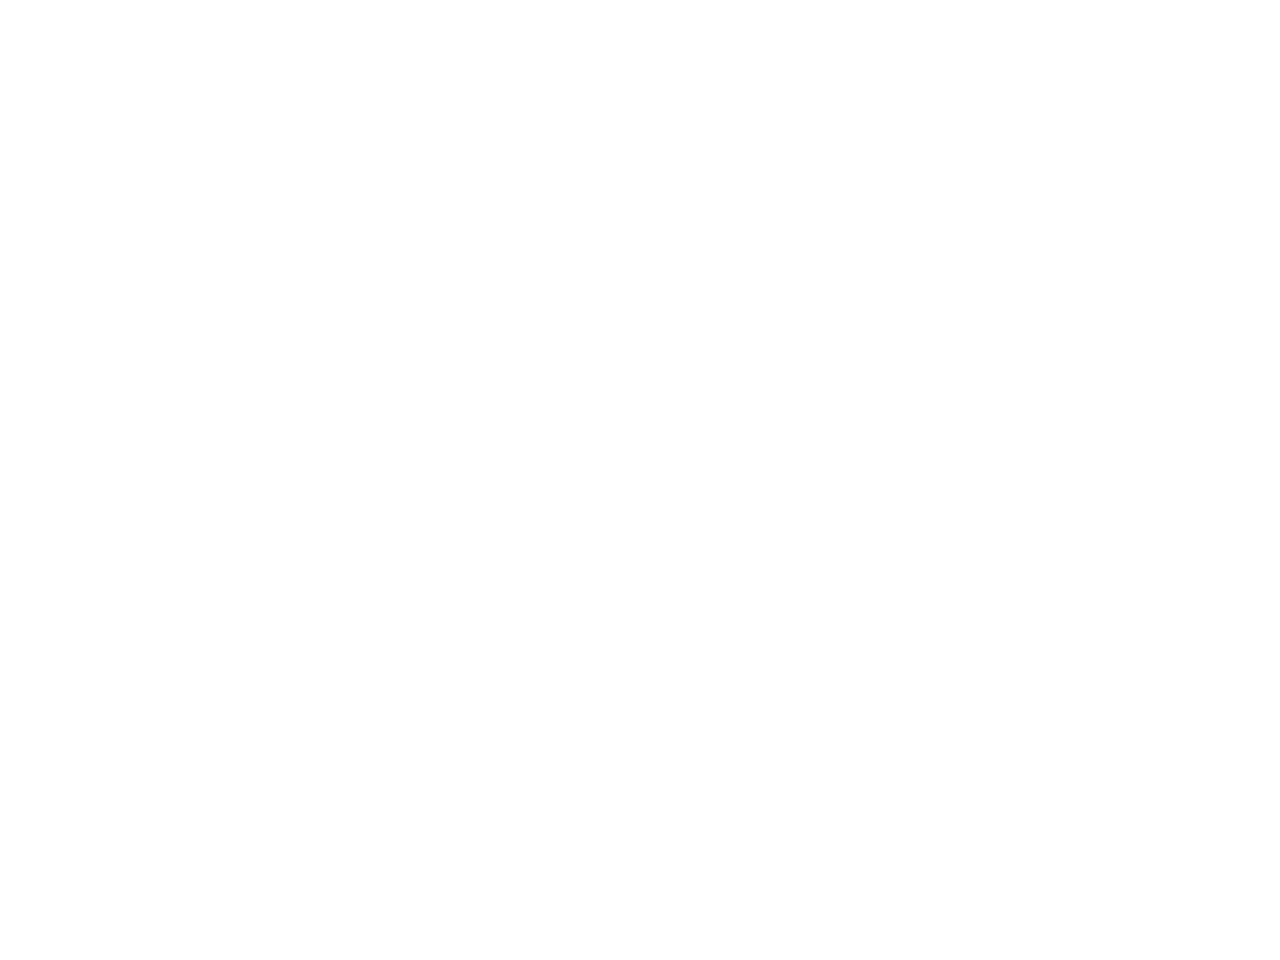

In [12]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
t=0
plt.plot(history['x', t], history['y', t], alpha=0.5, linewidth = '2')
plt.scatter(history['strategies', t], history['strategies_y', t],c = list(range(0,sim_config['num_bots'])), cmap='rainbow', alpha=0.8)
plt.xlabel('location x')
plt.ylabel('Payoff')
plt.title('payoff at period 0')
plt.colorbar(label='index')
plt.grid()
plt.show()

output_name = 'classic_'+ sim_config['initial_distribution']+ str(sim_config['initial_xmin'])+ '_'+str(sim_config['initial_xmax'])+'_bots' + str(sim_config['num_bots']) +'_trembling' +str(sim_config['trembling'])+'_lam' +str(sim_config['lambda'])+'_gam' +str(sim_config['gamma'])+'_c' +str(sim_config['c'])+'_k' +str(sim_config['k'])+'_length' +str(sim_config['game_length'])
plt.savefig(output_name + '_period0.png', bbox_inches='tight')

In [ ]:
range_end=100

import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera

fig = plt.figure(figsize=(8,8))
camera = Camera(fig)
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])
plt.ion()

# fig.show()
# fig.canvas.draw()

for i in range(range_end+1):
#     ax1.clear()
    
    graph = ax1.scatter(history['strategies', i], history['strategies_y', i],c = list(range(0,sim_config['num_bots'])), cmap='rainbow', alpha=0.4)
    ax1.set_xlabel('location x')
    ax1.set_ylabel('Payoff')
#     ax1.set_title('payoff')
    ax1.grid()
    ax1.set_xlim([4, 17])
    ax1.set_ylim([0, 105])
#     ax1.set_ylim([0, 1.2])
    
    plt.pause(0.001)
    ax1.text(0.4, 1.05, 'Period ' + str(i), transform=ax1.transAxes,fontsize = 16)
#     fig.suptitle(game_type_specification + ' game: Period ' + str(i))
#     fig.canvas.draw()
    camera.snap()
    
animation = camera.animate()
output_name = 'classic_'+ sim_config['initial_distribution']+ str(sim_config['initial_xmin'])+ '_'+str(sim_config['initial_xmax'])+'_bots' + str(sim_config['num_bots']) +'_trembling' +str(sim_config['trembling'])+'_lam' +str(sim_config['lambda'])+'_gam' +str(sim_config['gamma'])+'_c' +str(sim_config['c'])+'_k' +str(sim_config['k'])+'_length' +str(sim_config['game_length'])
animation.save(output_name + '.gif')     
print('Done')

In [ ]:
####################################################################################
########## after finishing simulation, run this cell to make graphs ############
############################### 'graphing' cell #################################
####################################################################################

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt


player_index = list(range(sim_config['num_bots']))

fig = plt.figure(figsize=(8,8))
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(round_idx+1):
    fig.clear()
    plt.plot(history['x', i], history['y', i], alpha=0.5, linewidth = '2', c='b')
    plt.scatter(history['strategies', i], history['strategies_y', i],c = list(range(0,sim_config['num_bots'])), cmap='rainbow', alpha=0.4)
    plt.xlabel('time x')
    plt.ylabel('Payoff')
    plt.title('payoff')
    plt.grid()
    plt.xlim([0, 20])
#     plt.ylim([0, 1.2])
    plt.ylim([0, 140])
    
    
    plt.pause(0.1)
    fig.suptitle('Period ' + str(i))
    fig.canvas.draw()


print('Done')

<IPython.core.display.Javascript object>


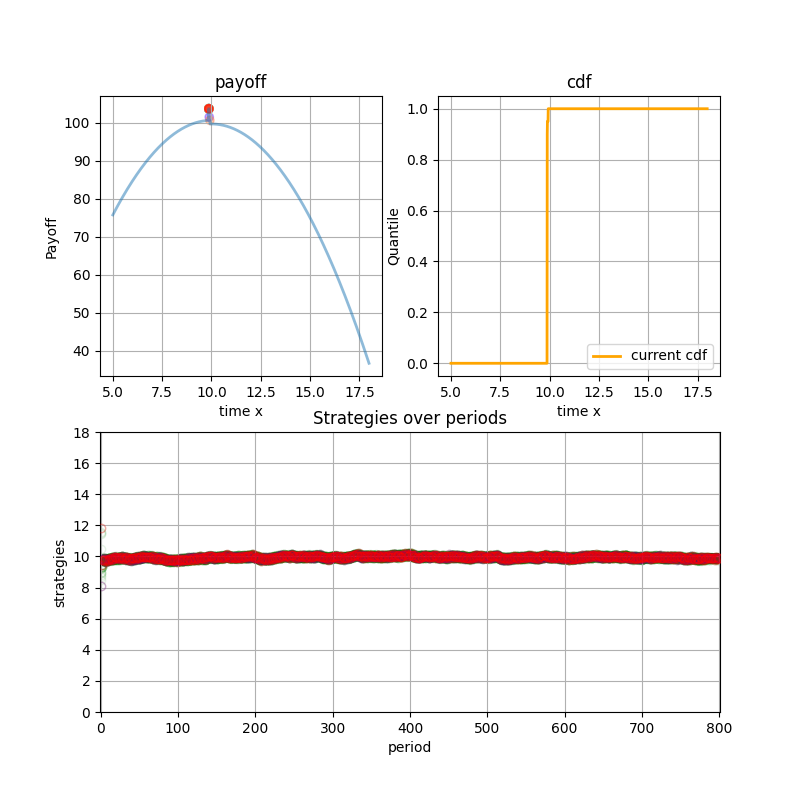

Done


In [3]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

player_index = list(range(sim_config['num_bots']))

fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(round_idx+1):
    ax1.clear()
    ax1.plot(history['x', i], history['y', i], alpha=0.5, linewidth = '2')
    graph = ax1.scatter(history['strategies', i], history['strategies_y', i],c = list(range(0,sim_config['num_bots'])), cmap='rainbow', alpha=0.4)
    
    ax1.set_xlabel('time x')
    ax1.set_ylabel('Payoff')
    ax1.set_title('payoff')
    ax1.grid()
#     ax1.legend()

   
    ax2.clear()
    ax2.plot(history['x', i], history['quantile', i], linewidth = '2', label='current cdf',c='orange')
    ax2.set_xlabel('time x')
    ax2.set_ylabel('Quantile')
    ax2.set_title('cdf')
    ax2.grid()
    ax2.legend()
    
    plot_round = np.array([i]*len(history['strategies', 0]))
    ax3.plot(plot_round, history['strategies', i], 'go', fillstyle='none', alpha=0.1, zorder=1)
    ax3.plot(plot_round[0], history['strategies', i][0], color='#800080', marker='o', fillstyle='none', alpha=0.3, zorder=2)
    ax3.plot(plot_round[-1], history['strategies', i][-1], 'ro', fillstyle='none', alpha=0.3, zorder=3)

    ax3.set_xlim([-1, round_idx+1])
    ax3.set_ylim([0, sim_config['xmax']])
    ax3.set_xlabel('period')
    ax3.set_ylabel('strategies')
    ax3.set_title('Strategies over periods')
    ax3.grid()

    
    
    plt.pause(0.001)
#     fig.suptitle(game_type_specification + ' (lambda, gamma, rho) = '+ '(' + str(sim_config['lambda']) + ', ' + str(sim_config['gamma']) + ', ' + str(sim_config['rho']) + ')' + ': Period ' + str(i))
    fig.canvas.draw()
# output_name = 'classic_'+ sim_config['initial_distribution']+ str(sim_config['initial_xmin'])+ '_'+str(sim_config['initial_xmax'])+'_bots' + str(sim_config['num_bots']) +'_trembling' +str(sim_config['trembling'])+'_lam' +str(sim_config['lambda'])+'_gam' +str(sim_config['gamma'])+'_c' +str(sim_config['c'])+'_k' +str(sim_config['k'])+'_length' +str(sim_config['game_length'])
# fig.savefig(output_name + '_end.png', dpi=fig.dpi, bbox_inches='tight')

print('Done')

<IPython.core.display.Javascript object>


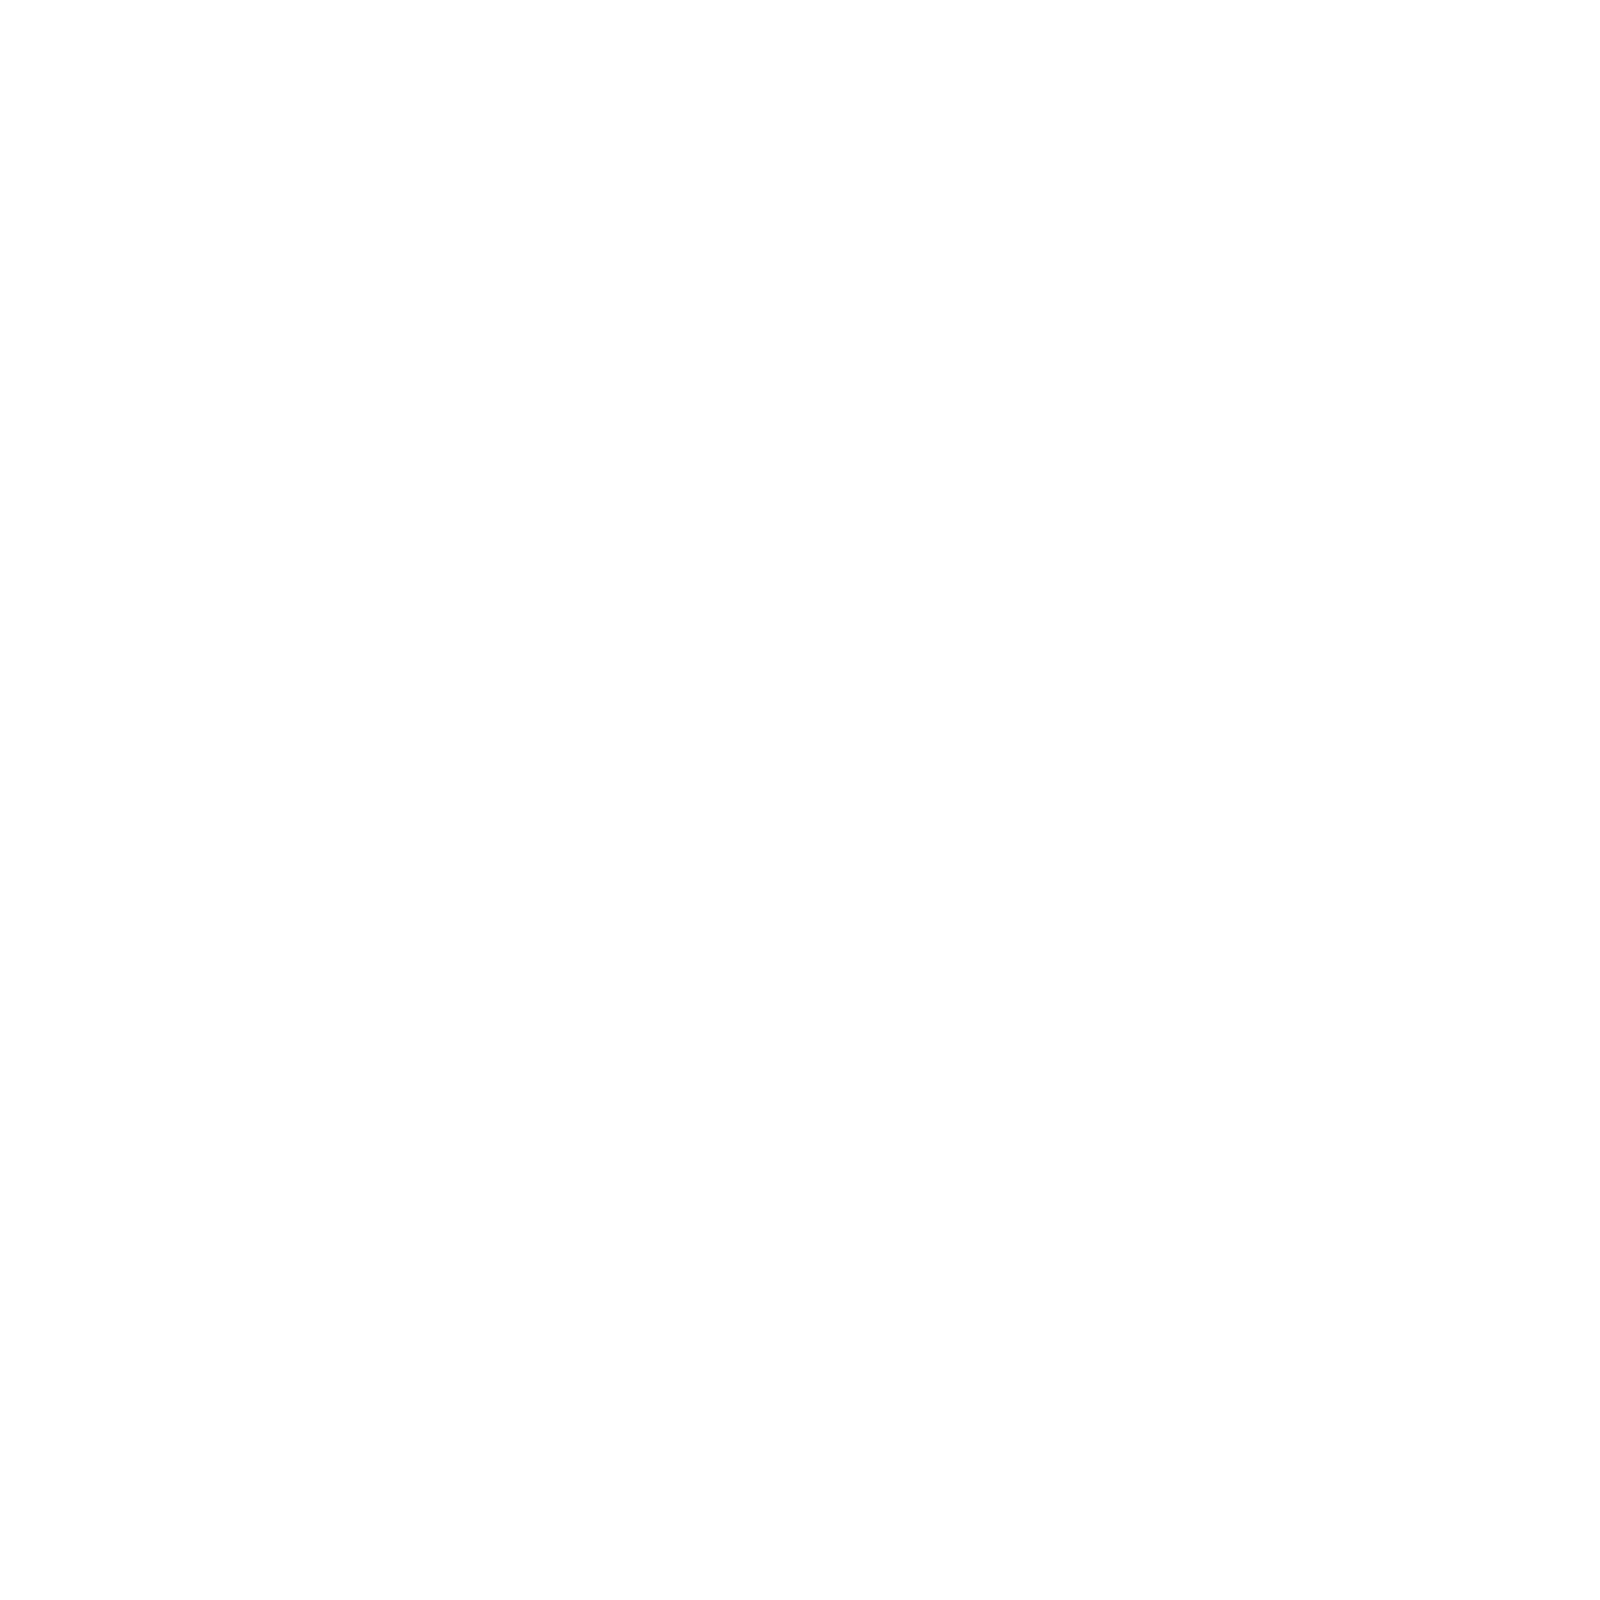

MovieWriter ffmpeg unavailable; using Pillow instead.


Done


In [13]:
range_end=200

import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera

fig = plt.figure(figsize=(8,8))
camera = Camera(fig)
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
plt.ion()

# fig.show()
# fig.canvas.draw()

for i in range(range_end+1):
#     ax1.clear()
    ax1.plot(history['x', i], history['y', i], alpha=0.5, linewidth = '2', c='b')
    graph = ax1.scatter(history['strategies', i], history['strategies_y', i],c = list(range(0,sim_config['num_bots'])), cmap='rainbow', alpha=0.4)
    ax1.set_xlabel('location x')
    ax1.set_ylabel('Payoff')
    ax1.set_title('payoff')
    ax1.grid()
#     ax1.set_xlim([4, 17])
#     ax1.set_ylim([0, 105])
#     ax1.set_ylim([0, 1.2])

#     ax2.clear()
    ax2.plot(history['x', i], history['quantile', i], linewidth = '2', label='current cdf', c='orange')
    ax2.set_xlabel('location x')
    ax2.set_ylabel('Quantile')
    ax2.set_title('cdf')
    ax2.grid()
#     ax2.legend(('current cdf', 'NE cdf'))
    
    for rd in range(i):
        plot_round = np.array([rd]*len(history['strategies', 0])) 
        ax3.plot(plot_round, history['strategies', rd], 'go', fillstyle='none', alpha=0.1, zorder=1)
    ax3.set_ylim([0, sim_config['xmax']])
    ax3.set_xlabel('period')
    ax3.set_ylabel('strategies')
    ax3.set_title('Strategies over periods')
    ax3.grid()
    
    plt.pause(0.001)
    ax1.text(0.9, 1.1, 'Period ' + str(i), transform=ax1.transAxes,fontsize = 16)
#     fig.suptitle(game_type_specification + ' game: Period ' + str(i))
#     fig.canvas.draw()
    camera.snap()
    
animation = camera.animate()
output_name = 'classic_'+ sim_config['initial_distribution']+ str(sim_config['initial_xmin'])+ '_'+str(sim_config['initial_xmax'])+'_bots' + str(sim_config['num_bots']) +'_trembling' +str(sim_config['trembling'])+'_lam' +str(sim_config['lambda'])+'_gam' +str(sim_config['gamma'])+'_c' +str(sim_config['c'])+'_k' +str(sim_config['k'])+'_length' +str(sim_config['game_length'])
animation.save(output_name + '.gif')     
print('Done')